# Project Title: Digit Recognizer
#### Author: James Coffey
#### Date: 2025-07-28
#### Challenge URL: [Digit Recognizer](https://www.kaggle.com/competitions/digit-recognizer)

In [ ]:
# Basic libraries
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from pathlib import Path
from collections import Counter
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Classical ML
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC, SVC

# Deep Learning
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import keras_tuner as kt
from keras_tuner import BayesianOptimization

# Utility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
DATA = Path('/kaggle/input/digit-recognizer')

2025-07-28 22:45:33.643711: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753742733.667819   19856 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753742733.674994   19856 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Dataset Access & Overview

In [2]:
train_df = pd.read_csv(DATA/'train.csv')
test_df  = pd.read_csv(DATA/'test.csv')

print(train_df.shape, test_df.shape)
train_df.head()

(42000, 785) (28000, 784)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Sanity checks

### NaNs

In [ ]:
assert not train_df.isna().any().any(), "Missing values detected in train"
assert not test_df.isna().any().any(),  "Missing values detected in test"

### Pixel range

In [ ]:
pixels = train_df.drop('label', axis=1)
assert pixels.min().min() >= 0 and pixels.max().max() <= 255, "Pixel out of 0-255 range"

### Duplicates

In [ ]:
dup_mask = pixels.duplicated(keep='first')
print(f'Exact duplicate images in train: {dup_mask.sum()}')

Exact duplicate images in train: 0


## Label distribution

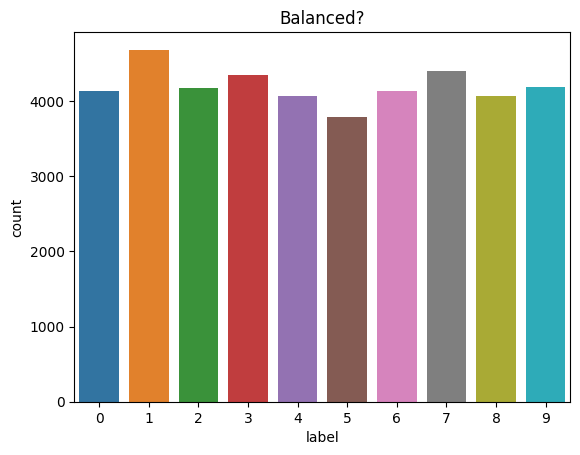

In [ ]:
sns.countplot(x=train_df.label); plt.title('Balanced?')
plt.show()

##  Convert to image tensors

In [ ]:
X = train_df.drop('label', axis=1).values.reshape(-1,28,28,1).astype('float32') / 255.
y = train_df.label.values
X_test = test_df.values.reshape(-1,28,28,1).astype('float32') / 255.

## Findings

* Train missing: 0
* Test missing: 0
* A roughly uniform bar chart over digits 0–9
* Pixel values range from 0 to 255
* Number of exact-duplicate images in train: 0

# Quick Quality Checks

In [ ]:
assert X.min()>=0 and X.max()<=1, "Pixel range outside 0-1!"

## Visual sanity-check

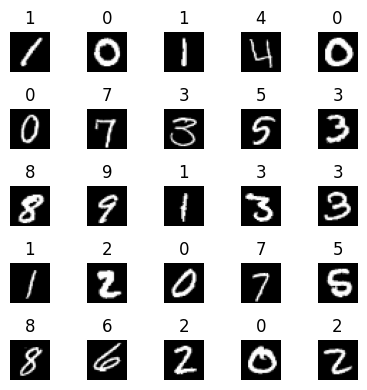

In [ ]:
fig, axs = plt.subplots(5,5, figsize=(4,4))
for ax, img, label in zip(axs.flat, X[:25], y[:25]):
    ax.imshow(img.squeeze(), cmap='gray'); ax.set_title(label); ax.axis('off')
plt.tight_layout()

# Mini-EDA

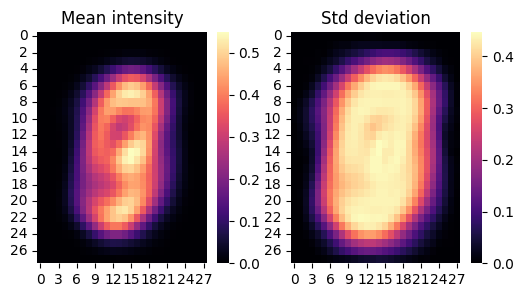

In [7]:
mean_img = X.mean(axis=0).squeeze()
std_img  = X.std(axis=0).squeeze()

fig, ax = plt.subplots(1,2, figsize=(6,3))
sns.heatmap(mean_img, ax=ax[0], cmap='magma');  ax[0].set_title('Mean intensity')
sns.heatmap(std_img , ax=ax[1], cmap='magma');  ax[1].set_title('Std deviation')
plt.show()

## Ink centroid per digit

In [ ]:
centroids = {}
for d in range(10):
    mask = y==d
    xs, ys = np.where(X[mask].mean(axis=0).squeeze()>0.1)
    centroids[d] = (xs.mean(), ys.mean())
pd.DataFrame(centroids, index=['row','col']).T

,row,col
0,13.903333,14.233333
1,13.520548,14.095890
2,13.824916,14.107744
3,13.967033,13.794872
4,13.896552,14.057471
5,13.979021,14.192308
6,13.095057,14.144487
7,14.500000,13.642857
8,14.035714,14.067857
9,14.743802,13.913223


# Baselines

In [9]:
# Flatten once
X_flat = X.reshape(len(X), -1)

## K-Nearest Neighbors

In [ ]:
knn_pipe = Pipeline([
    ('minmax', MinMaxScaler()),
    ('knn',    KNeighborsClassifier(n_neighbors=3, metric='euclidean'))
])
knn_pipe.fit(X_flat, y)

pred = knn_pipe.predict(X_flat)
print('Train acc (KNN):', accuracy_score(y, pred))

Train acc (KNN): 0.9837619047619047


## PCA + Linear SVM

In [ ]:
pca_svm_pipe = Pipeline([
    ('scale', StandardScaler()),
    ('pca',   PCA(n_components=50, random_state=SEED)),
    ('svm',   LinearSVC(C=1.0, dual=False, random_state=SEED))
])
pca_svm_pipe.fit(X_flat, y)
print('Train acc (PCA+SVM):', accuracy_score(y, pca_svm_pipe.predict(X_flat)))

Train acc (PCA+SVM): 0.8934047619047619


# Convolutional Neural Network (CNN) Model

In [ ]:
def build_model(hp=None):
    # Conv block 1
    filters1 = hp.Choice('filters1', [16, 32, 64, 128])
    ks1      = hp.Choice('kernel1',  [1, 3, 5])
    # Conv block 2
    filters2 = hp.Choice('filters2', [32, 64, 128])
    ks2      = hp.Choice('kernel2',  [1, 3, 5])
    # Dense layer
    dense_units = hp.Int('dense', 64, 512, step=64)
    # Regularization
    dr_rate  = hp.Float('dropout', 0.2, 0.5, step=0.1)
    lr       = hp.Float('lr', 1e-4, 1e-2, sampling='log')

    model = tf.keras.Sequential([
        layers.Input((28, 28, 1)),
        layers.Conv2D(filters1, ks1, activation='relu', padding='same'),
        layers.Conv2D(filters2, ks2, activation='relu', padding='same'),
        layers.MaxPooling2D(),
        layers.Dropout(dr_rate),
        layers.Flatten(),
        layers.Dense(dense_units, activation='relu'),
        layers.Dropout(dr_rate),
        layers.Dense(10, activation='softmax')
    ])

    model.compile(
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr),
        loss      = 'sparse_categorical_crossentropy',
        metrics   = ['accuracy']
    )
    return model

## Data augmentation

In [ ]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=10, width_shift_range=0.1, height_shift_range=0.1)
datagen.fit(X)

##  Train/val split

In [ ]:
X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=0.1,
                                            stratify=y, random_state=SEED)

# Hyper-parameter Tuning (≤40 trials)

In [ ]:
def run_bayes_tuner():
    tuner = BayesianOptimization(
        build_model,
        objective='val_accuracy',
        max_trials=40,
        num_initial_points=8,
        directory='mnist_tuning',
        project_name='cnn_bo',
        overwrite=True,
        seed=SEED
    )

    tuner.search(
        datagen.flow(X_tr, y_tr, batch_size=128),
        validation_data=(X_val, y_val),
        epochs=15,
        callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)]
    )

    # Early-exit logic
    hist = [t.metrics.get_last_value('val_accuracy')
            for t in tuner.oracle.trials.values()]
    if len(hist) > 10 and max(hist[-10:]) - max(hist[:-10]) < 1e-3:
        print("No meaningful gain in 10 trials – stopping search early.")

    # Always return *both* artifacts
    best_model = tuner.get_best_models(1)[0]
    best_hp    = tuner.get_best_hyperparameters(1)[0]
    return best_model, best_hp

best_model, best_hp = run_bayes_tuner()

Trial 3 Complete [00h 02m 45s]
val_accuracy: 0.9645237922668457

Best val_accuracy So Far: 0.9895238280296326
Total elapsed time: 00h 08m 18s


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


# Cross-Validation

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
cv_scores = []

for fold, (tr, va) in enumerate(skf.split(X, y), 1):
    model = build_model(best_hp)
    model.fit(datagen.flow(X[tr], y[tr], batch_size=128),
              epochs=15, verbose=0,
              validation_data=(X[va], y[va]),
              callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)])
    acc = model.evaluate(X[va], y[va], verbose=0)[1]
    cv_scores.append(acc)
    print(f'Fold {fold}: {acc:.4f}')

print(f'CV mean ± std: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}')

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Fold 1: 0.9892
Fold 2: 0.9888
Fold 3: 0.9879
Fold 4: 0.9899
Fold 5: 0.9876
CV mean ± std: 0.9887 ± 0.0008


# Confusion Matrix

132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


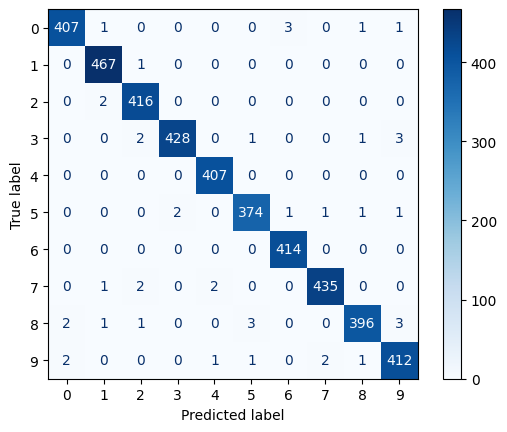

In [26]:
val_pred = np.argmax(best_model.predict(X_val), axis=1)
cm = confusion_matrix(y_val, val_pred)
ConfusionMatrixDisplay(cm).plot(cmap='Blues'); plt.show()

# Train on Full Data & Generate Submission

In [68]:
best_model.fit(datagen.flow(X, y, batch_size=128),
               epochs=12, callbacks=[callbacks.EarlyStopping(patience=3)])
test_pred = np.argmax(best_model.predict(X_test), axis=1)

sub = pd.DataFrame({'ImageId': np.arange(1, len(X_test)+1),
                    'Label': test_pred})
sub.to_csv('submission.csv', index=False)

Epoch 1/12


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


329/329 ━━━━━━━━━━━━━━━━━━━━ 16s 37ms/step - accuracy: 0.9204 - loss: 0.9468
Epoch 2/12
  5/329 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.8596 - loss: 1.5030

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.8503 - loss: 1.6041
Epoch 3/12
329/329 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.7853 - loss: 2.0215
Epoch 4/12
329/329 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.7652 - loss: 2.1278
Epoch 5/12
329/329 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - accuracy: 0.7710 - loss: 2.1134
Epoch 6/12
329/329 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.7774 - loss: 2.1288
Epoch 7/12
329/329 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - accuracy: 0.7558 - loss: 2.1663
Epoch 8/12
329/329 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - accuracy: 0.7502 - loss: 2.1772
Epoch 9/12
329/329 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.7534 - loss: 2.2009
Epoch 10/12
329/329 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.7452 - loss: 2.2172
Epoch 11/12
329/329 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.7269 - loss: 2.2443
Epoch 12/12
329/329 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.6863 - loss: 2.2284
875/875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,2
